In [2]:
#In case you don't have qiskit, install it now
%pip install qiskit --quiet
#Installing/upgrading pylatexenc seems to have fixed my mpl issue
#If you try this and it doesn't work, try also restarting the runtime/kernel
%pip install pylatexenc --quiet

#Let's go ahead and import all this stuff too
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.quantum_info import Statevector
import numpy as np
import random
import math
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector

In [47]:
n = 4
num_clauses = 8
aux_num = num_clauses + 1
variables = QuantumRegister(n, name='clauses')
auxes = QuantumRegister(aux_num, name='auxes')
U = QuantumCircuit(variables, auxes)
expression = []

for i in range(num_clauses):
    clause = []
    for j in range(3):
        to_add = random.randint(0, n - 1)
        while (to_add in clause):
            to_add = random.randint(0, n - 1)
        clause.append(to_add)
    expression.append(clause)

not_list = []
for i in range(num_clauses * 3):
    not_list.append(random.randint(0,1))

print(expression)
print(not_list)

for i in range(num_clauses):    
    for j in range(3):
        if (not not_list[j + i*3]):
         U.x(expression[i][j])
    U.x(auxes[i])
    U.mcx(expression[i], auxes[i])
    for j in range(3):
        if (not not_list[j + i*3]):
         U.x(expression[i][j])

    #or the result of the first two and the third
    U.barrier()

U.mcx(auxes[:-1], auxes[-1])    

[[0, 1, 3], [2, 1, 0], [0, 1, 2], [3, 2, 1], [3, 1, 0], [2, 1, 3], [0, 3, 2], [3, 0, 1]]
[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1]


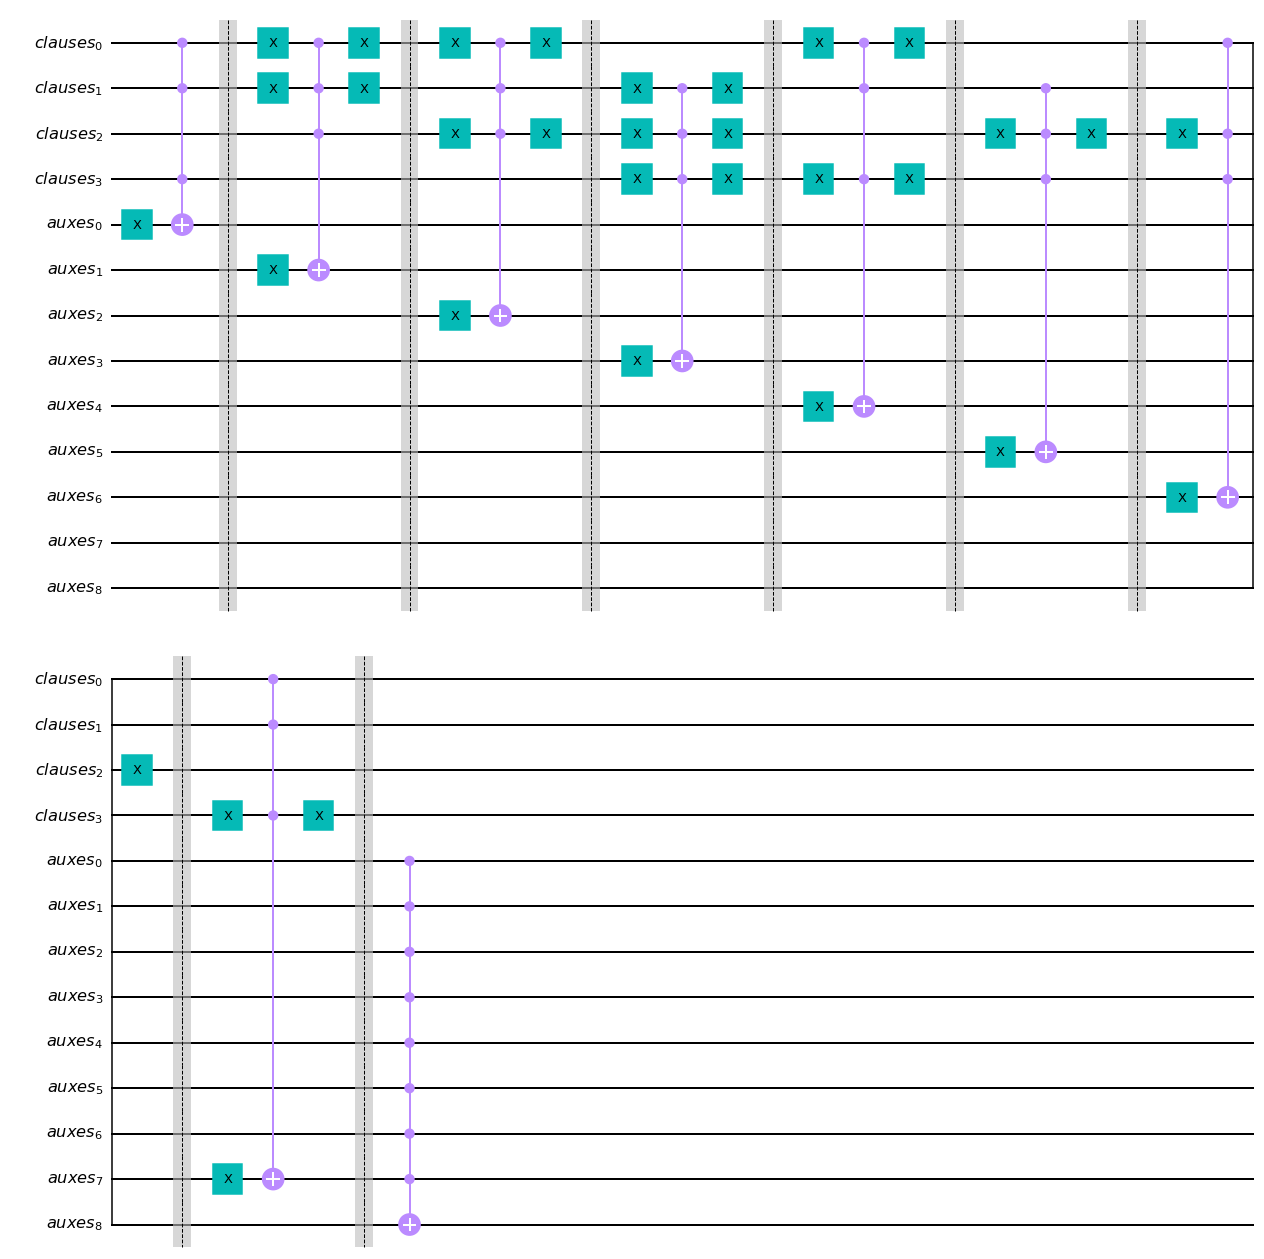

In [48]:
U.draw('mpl', filename='graph.png')


In [49]:
solutions = 0
for i in range(2 ** n):
    vals = []
    for j in range(n):
        vals.append((i >> j) & 1)

    result = 1
    for j in range(num_clauses):
        first = vals[expression[j][0]] ^ not_list[j*3]
        second = vals[expression[j][1]] ^ not_list[j*3 + 1]
        third = vals[expression[j][2]] ^ not_list[j*3 + 2]
        result &= (first | second | third)
    if result:
        solutions += 1
        print(vals[::-1])
print(f'num_solutions is {solutions}')
print(not_list)
print(expression)

[0, 1, 0, 1]
[1, 0, 0, 0]
[1, 1, 0, 1]
[1, 1, 1, 0]
num_solutions is 4
[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1]
[[0, 1, 3], [2, 1, 0], [0, 1, 2], [3, 2, 1], [3, 1, 0], [2, 1, 3], [0, 3, 2], [3, 0, 1]]


4, 4
1


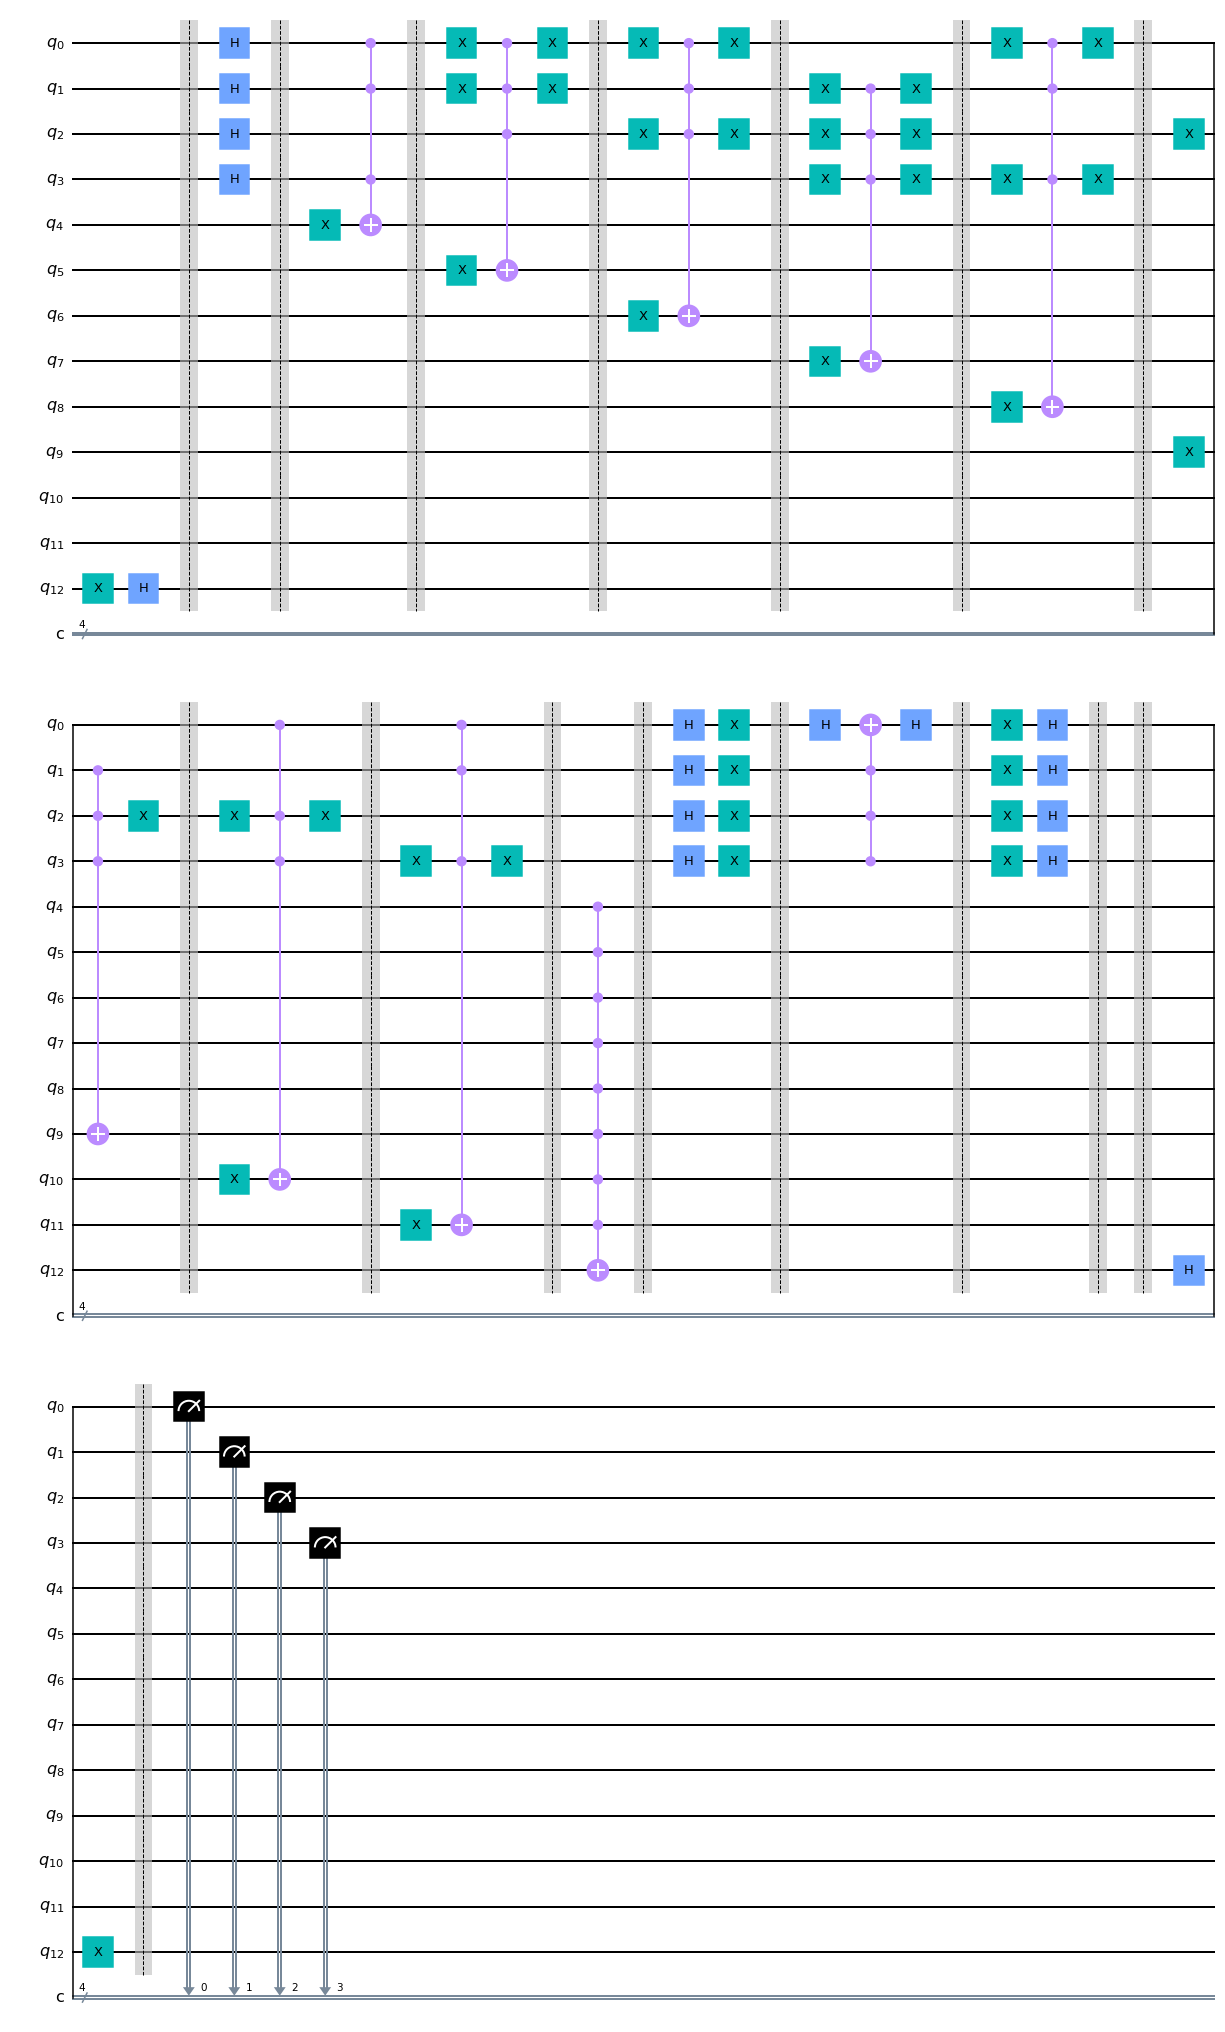

In [50]:
#running grovers
x = QuantumRegister(n, name='x')
auxes = QuantumRegister(aux_num - 1, name='aux')
y = QuantumRegister(1, name='y')
classical = ClassicalRegister(n)
qc = QuantumCircuit(n + aux_num, n)
last = n + aux_num - 1
qc.x(last)
qc.h(last)
qc.barrier()
qc.h(range(n))
R = math.floor(np.pi * np.sqrt((n ** 2) / solutions) / 4)
print(f'{n}, {solutions}')
print(R)
# test = QuantumCircuit(1,1)
# test.x(0)
# qc.compose(U, inplace=True)
qc.barrier()
for i in range(R):
    qc.compose(U, inplace=True)
    #w
    qc.barrier()
    for j in range(0, n):
        qc.h(j)
        qc.x(j)
    qc.barrier()
    qc.h(0)
    qc.mcx(list(range(1, n)), 0)
    qc.h(0)
    qc.barrier()
    for j in range(n):
        qc.x(j)
        qc.h(j)
    qc.barrier()
qc.barrier()
qc.h(last)
qc.x(last)
qc.barrier()
qc.measure(range(n), range(n))
qc.draw('mpl')

{'0001': 63, '1101': 23, '0010': 74, '1110': 33, '1000': 37, '0110': 77, '0100': 68, '1011': 89, '0011': 68, '0000': 63, '0111': 84, '0101': 27, '1100': 65, '1001': 79, '1010': 73, '1111': 101}


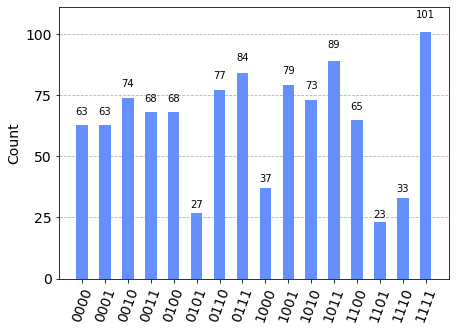

In [51]:
#Simulate your circuit!
backend = Aer.get_backend('qasm_simulator')
counts= execute(qc,backend, shots=1024).result().get_counts(qc)
print(counts)
plot_histogram(counts)